<a href="https://colab.research.google.com/github/LogBlast/projectdata_group6/blob/notebook/project_group6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project Submission - Group 6***

# 1) Data importation

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

df = pd.read_csv("online_gaming_behavior_dataset.csv")
df

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(column, errors="raise")


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,49029,32,Male,USA,Strategy,20.619662,0,Easy,4,75,85,14,Medium
40030,49030,44,Female,Other,Simulation,13.539280,0,Hard,19,114,71,27,High
40031,49031,15,Female,USA,RPG,0.240057,1,Easy,10,176,29,1,High
40032,49032,34,Male,USA,Sports,14.017818,1,Medium,3,128,70,10,Medium


# 2) Data cleaning

## a) Is null detection

*The dataset doesn't contain any null values because it's intended for data processing on Kaggle, and therefore must be cleaned and free of issues.*

In [ ]:
df.isnull().sum()
display(df)
print("The dataset is already clean")

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,49029,32,Male,USA,Strategy,20.619662,0,Easy,4,75,85,14,Medium
40030,49030,44,Female,Other,Simulation,13.539280,0,Hard,19,114,71,27,High
40031,49031,15,Female,USA,RPG,0.240057,1,Easy,10,176,29,1,High
40032,49032,34,Male,USA,Sports,14.017818,1,Medium,3,128,70,10,Medium


The dataset is already clean


## b) Preprocessing data

In [ ]:
# float
float_cols = df.select_dtypes(include='float').columns
df[float_cols] = df[float_cols].round().astype('int')

# numeric
numeric_columns = ["Age", "PlayTimeHours", "SessionsPerWeek", "PlayerLevel"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# missing values
df.dropna(subset=numeric_columns, inplace=True)

cat_cols = df.select_dtypes(include='object').columns

display(df.head())
print(df.info())



,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,6,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,16,0,Medium,2,131,95,37,Medium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   PlayerID                   40034 non-null  int64 
 1   Age                        40034 non-null  int64 
 2   Gender                     40034 non-null  object
 3   Location                   40034 non-null  object
 4   GameGenre                  40034 non-null  object
 5   PlayTimeHours              40034 non-null  int64 
 6   InGamePurchases            40034 non-null  int64 
 7   GameDifficulty             40034 non-null  object
 8   SessionsPerWeek            40034 non-null  int64 
 9   AvgSessionDurationMinutes  40034 non-null  int64 
 10  PlayerLevel                40034 non-null  int64 
 11  AchievementsUnlocked       40034 non-null  int64 
 12  EngagementLevel            40034 non-null  object
dtypes: int64(8), object(5)
memory usage: 4.0+ MB
None


# 3) New Features

## a) Engagement Efficiency

,PlayerID,PlayTimeHours,AchievementsUnlocked,EngagementEfficiency
0,9000,16,25,1.56
1,9001,6,10,1.67
2,9002,8,41,5.12
3,9003,5,47,9.40
4,9004,16,37,2.31
5,9005,21,22,1.05
6,9006,10,2,0.20
7,9007,4,23,5.75
8,9008,18,41,2.28
9,9009,24,36,1.50


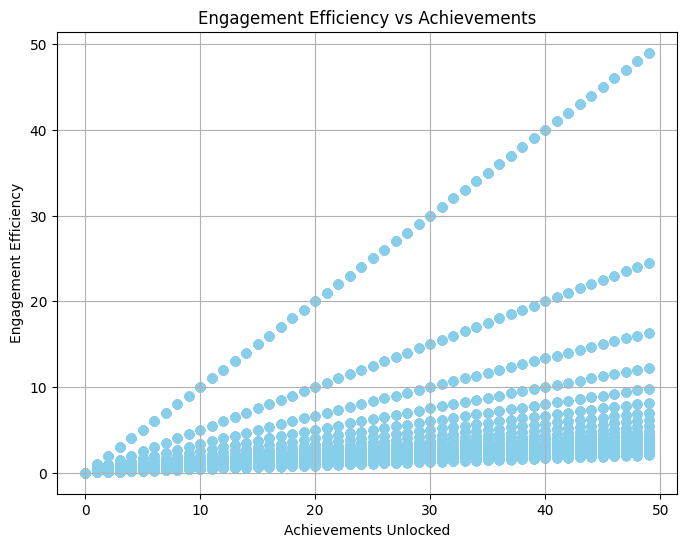

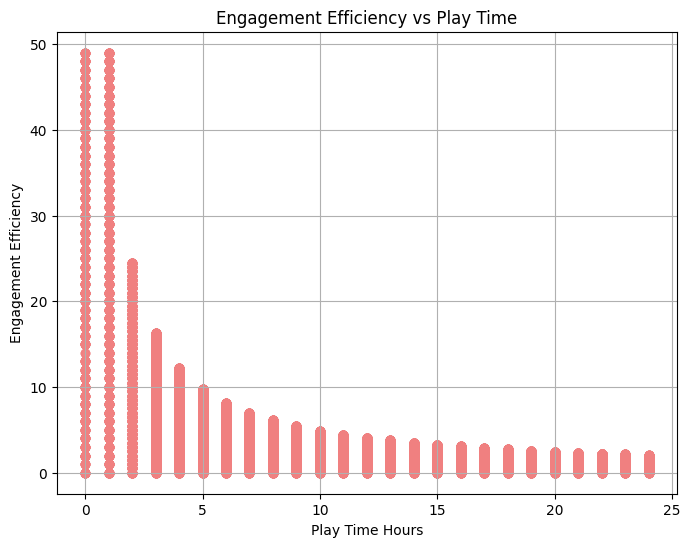

In [ ]:
df['EngagementEfficiency'] = df['AchievementsUnlocked'] / df['PlayTimeHours'].replace(0, 1)
df['EngagementEfficiency'] = df['EngagementEfficiency'].round(2)

display(df[['PlayerID', 'PlayTimeHours', 'AchievementsUnlocked', 'EngagementEfficiency']].head(10))

# plot 1
plt.figure(figsize=(8, 6))
plt.scatter(df['AchievementsUnlocked'], df['EngagementEfficiency'], color='skyblue', alpha=0.6)
plt.title('Engagement Efficiency vs Achievements')
plt.xlabel('Achievements Unlocked')
plt.ylabel('Engagement Efficiency')
plt.grid(True)
plt.show()

# plot 2
plt.figure(figsize=(8, 6))
plt.scatter(df['PlayTimeHours'], df['EngagementEfficiency'], color='lightcoral', alpha=0.6)
plt.title('Engagement Efficiency vs Play Time')
plt.xlabel('Play Time Hours')
plt.ylabel('Engagement Efficiency')
plt.grid(True)
plt.show()

# 4) Data Visualization

## a) 'data' distribution

array([<Axes: title={'center': 'Female'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Male'}, ylabel='Frequency'>], dtype=object)

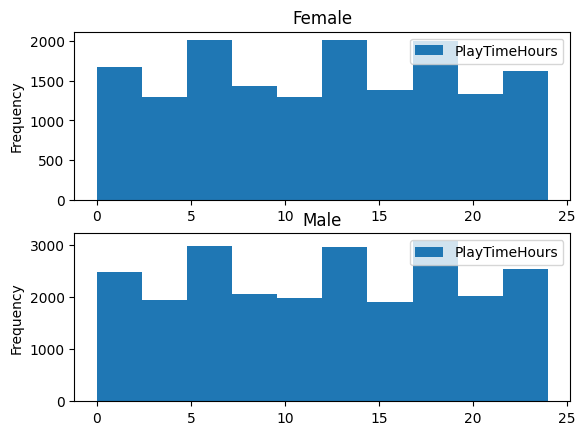

In [ ]:
df.plot.hist(by="Gender", column=["PlayTimeHours"])

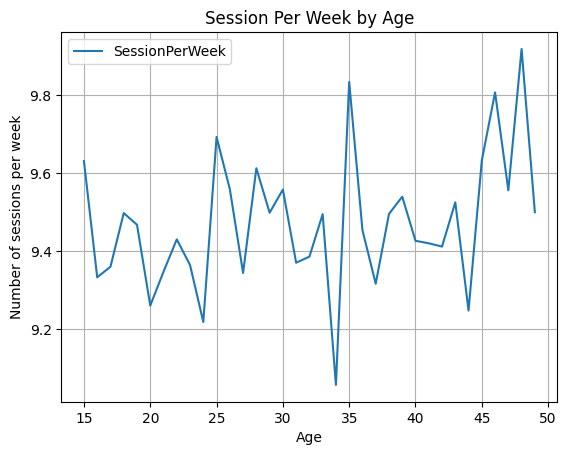

In [ ]:
df_avg_age = df.groupby("Age").mean("SessionPerWeek").reset_index()
plt.plot(df_avg_age["Age"], df_avg_age["SessionsPerWeek"], label="SessionPerWeek")
plt.xlabel("Age")
plt.ylabel("Number of sessions per week")
plt.grid(True)
plt.title("Session Per Week by Age")
plt.legend()
plt.show()

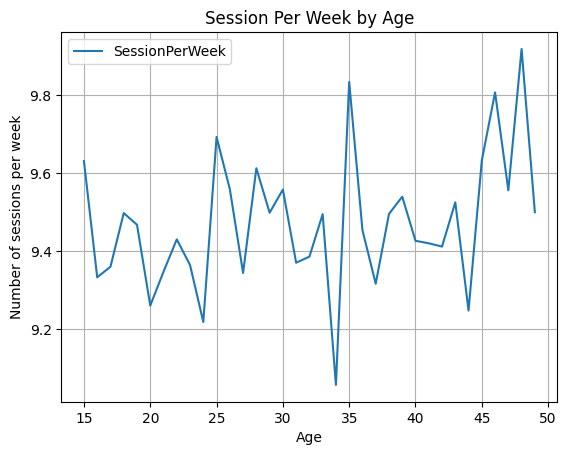

In [ ]:
df_avg_age = df.groupby("Age").mean("SessionPerWeek").reset_index()
plt.plot(df_avg_age["Age"], df_avg_age["SessionsPerWeek"], label="SessionPerWeek")
plt.xlabel("Age")
plt.ylabel("Number of sessions per week")
plt.grid(True)
plt.title("Session Per Week by Age")
plt.legend()
plt.show()

## b) influence of '' type

## c) Seaborn Plots (Pair Plot, Heatmap, Correlation Matrix)

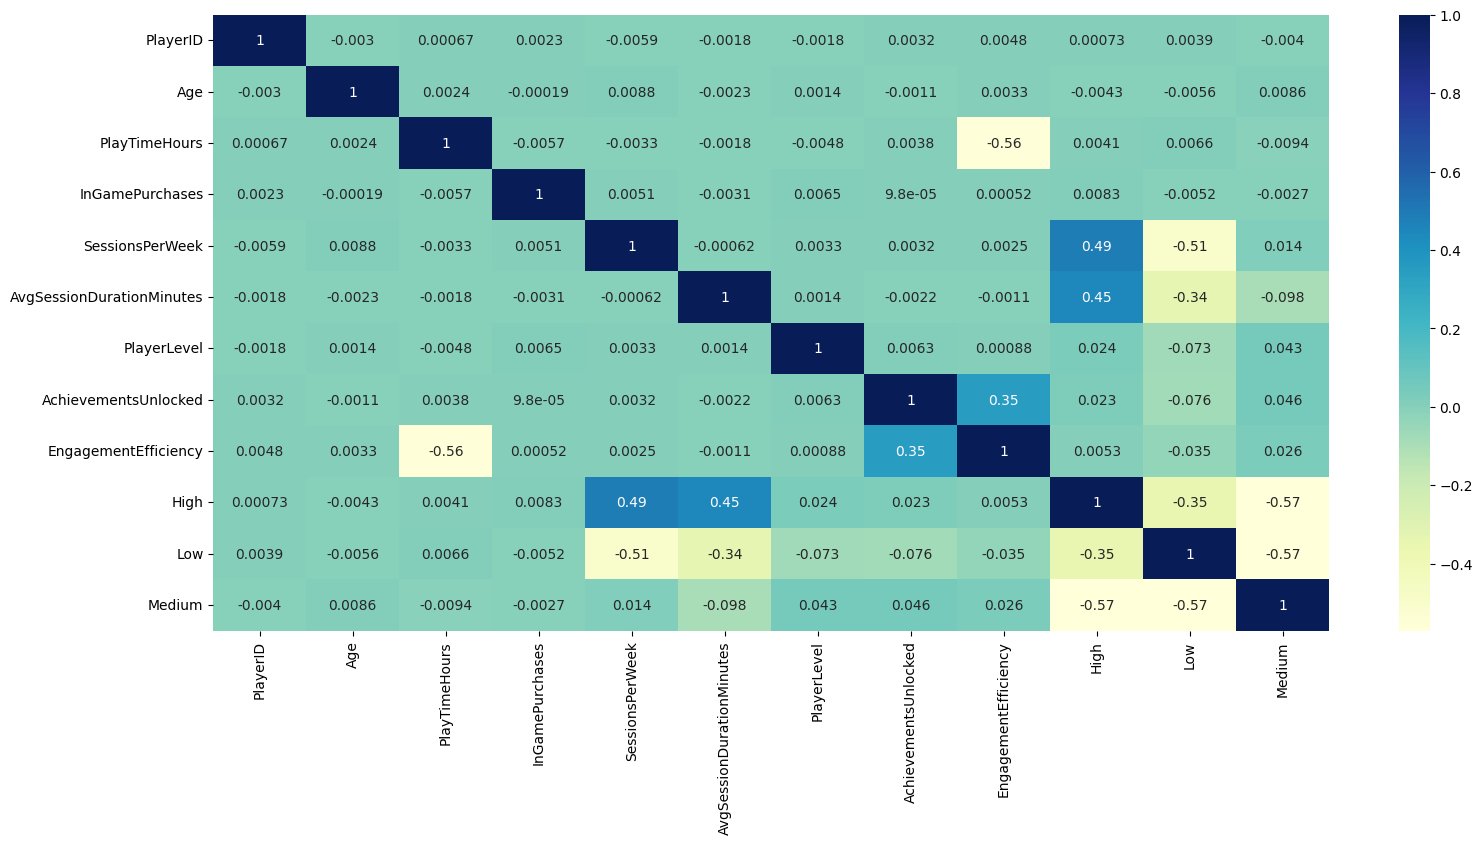

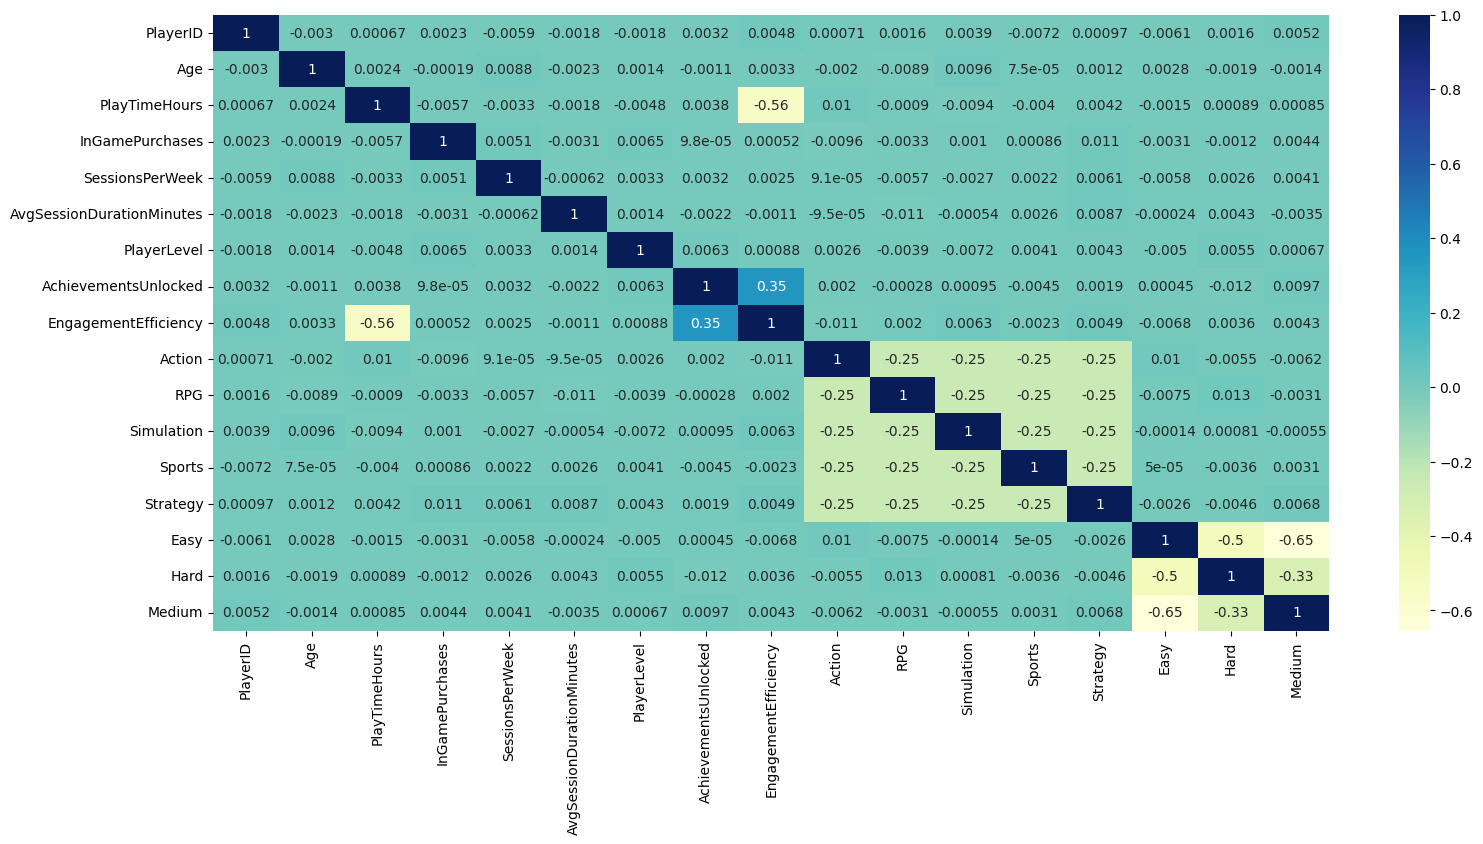

In [ ]:
# Exemple de code pour les pairs plot sur kaggle

gender_country_data = df.join(pd.get_dummies(df.Gender)).drop(['Gender'], axis=1)
gender_country_data = df.join(pd.get_dummies(df.Location)).drop(['Location'], axis=1)
gender_country_data = df.join(pd.get_dummies(df.EngagementLevel)).drop(['EngagementLevel'], axis=1)

plt.figure(figsize=(18,8))
sns.heatmap(gender_country_data.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.show()

# ----------------

df_dummies = df.join(pd.get_dummies(df.GameGenre)).drop(['GameGenre'], axis=1)
df_dummies = df_dummies.join(pd.get_dummies(df_dummies.GameDifficulty)).drop(['GameDifficulty'], axis=1)
corr_matrix = df_dummies.corr(numeric_only=True)

plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

#4) ML Model

## a) Setup Random Forest

In [ ]:
# target
target_column = 'EngagementLevel'

# seperate x y
X = df.drop(columns=[target_column, 'Gender', 'Location', 'GameGenre', 'GameDifficulty'])
y = df[target_column]

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# random forest
model = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    min_samples_split=15,
    min_samples_leaf=8,
    random_state=42
)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8377669539153241

Classification Report:
               precision    recall  f1-score   support

        High       0.88      0.78      0.83      2067
         Low       0.91      0.71      0.80      2065
      Medium       0.79      0.94      0.86      3875

    accuracy                           0.84      8007
   macro avg       0.86      0.81      0.83      8007
weighted avg       0.85      0.84      0.84      8007



## b) Macro-Micro Score

In [ ]:
from sklearn.metrics import f1_score

# macro micro f1
report = classification_report(y_test, y_pred, output_dict=True)
macro_f1 = report['macro avg']['f1-score']
micro_f1 = f1_score(y_test, y_pred, average='micro')

print("Macro F1-score:", macro_f1)
print("Micro F1-score:", micro_f1)

Macro F1-score: 0.8287283875164465
Micro F1-score: 0.8377669539153241


## c) Confusion Matrix

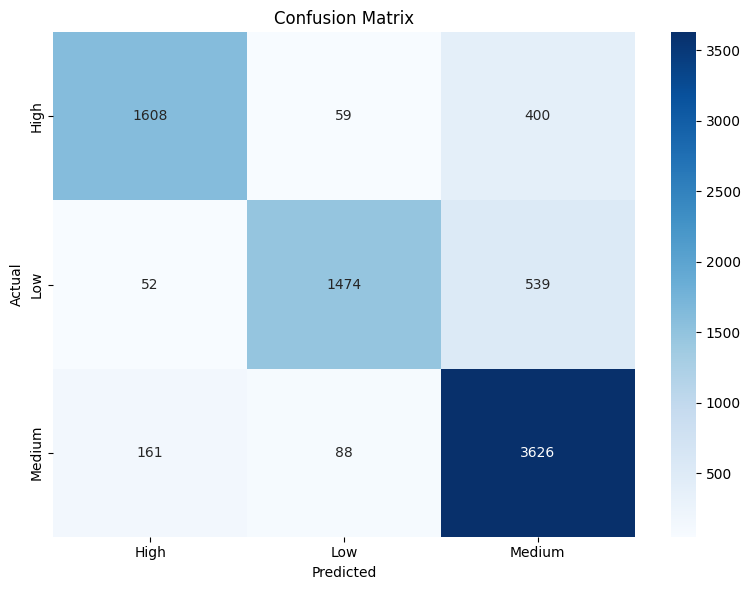

In [ ]:
# confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# feature importance
importances = model.feature_importances_
feat_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

## d) Top 15 Feature


Top 15 features:

                     Feature  Importance
4            SessionsPerWeek    0.632299
5  AvgSessionDurationMinutes    0.344857
6                PlayerLevel    0.007876
7       AchievementsUnlocked    0.007786
8       EngagementEfficiency    0.003765
0                   PlayerID    0.001574
1                        Age    0.001024
2              PlayTimeHours    0.000763
3            InGamePurchases    0.000054


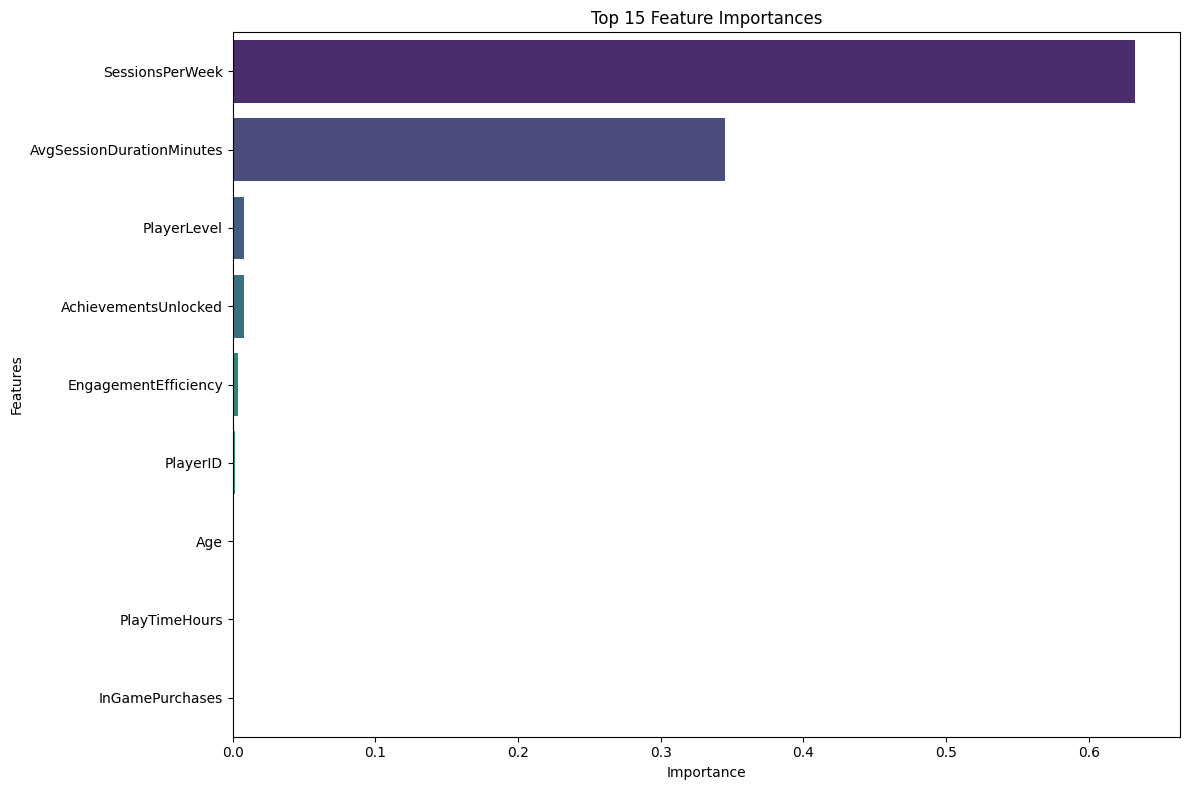

In [ ]:
# print
print("\nTop 15 features:\n")
print(importance_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## e) Cross Validation

In [ ]:
# cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Cross-validation Accuracy: 0.846 (+/- 0.004)


# 6) Responsible AI Practices

In [ ]:
# Data Privacy Check
print("--- Data Privacy ---")
print(f"Dataset contains {len(df)} player records")
print("Sensitive data handling:")
print("- Player IDs are anonymized")
print("- No personal information stored")
print("- Data used only for engagement analysis\n")

# 2. Bias Detection
print("--- Bias Analysis ---")

print("Gender distribution:")
print(df['Gender'].value_counts(normalize=True))

print("\nLocation distribution:")
print(df['Location'].value_counts(normalize=True))

# 3. Transparency

print(f"\n--- Model Transparency ---")
print("Model used: Random Forest")
print(f"Number of trees: {model.n_estimators}")
print(f"Max depth: {model.max_depth}")
print("Key features influencing predictions:")
print(importance_df.head(3)[['Feature', 'Importance']])

--- Data Privacy ---
Dataset contains 40034 player records
Sensitive data handling:
- Player IDs are anonymized
- No personal information stored
- Data used only for engagement analysis

--- Bias Analysis ---
Gender distribution:
Gender
Male      0.598466
Female    0.401534
Name: proportion, dtype: float64

Location distribution:
Location
USA       0.399660
Europe    0.299845
Asia      0.202203
Other     0.098291
Name: proportion, dtype: float64

--- Model Transparency ---
Model used: Random Forest
Number of trees: 50
Max depth: 5
Key features influencing predictions:
                     Feature  Importance
4            SessionsPerWeek    0.632299
5  AvgSessionDurationMinutes    0.344857
6                PlayerLevel    0.007876
